<div align="center">

# Final Project

ECON 294A Python Lab, Spring 2024, UC Santa Cruz

Theo Dubus

</div>

# Summary

This data was originally gathered as part of my independent study into residential solar adoption rates around the 2018 wildfire events. However, I am taking a different approach with this analysis by omitting the effects of the wildfire events and looking solely at the factors affecting solar adoption across counties in 2019. 

# Data

Due to the data I was able to gather, my analysis is a truncated version of what I intended in the proposal. Nevertheless, it will be helpful in gaining preliminary insights.

This data comes from two main sources: 

1. Demographic data was downloaded from the American Community Survey 5-Year estimates for 2019. Vairables include:
    - Median age of house holder, which measures only the head of household for the occupant of an owned or rented housing unit. This omits other factors in age like the presence of children, looking only at the age of those directly involved with the decison to adopt solar power for the property.
    - Median income
    - Percent of owners vs renters in the county
    - Education, measured seperately: percent of people who graduated high school, attained some college, and earned a bachelor's degree or higher.
    - Race: multiple racial groups were originionally downloaded in the data, but only 'Race_White' was kept to reduce bias in the estimates. Chnages in the white population are highly correlated with changes in multiple other groups simultaneously (for example, black and hispanic), so this caused too much self-correlation with the data.

2. Solar Installations per capita was calculated using the Distributed Generation Statistics dataset from the California Public Utilities Commission. Data was aggregated for each of the 53 counties studied in 2019. This was divided by the population in each county in 2019 gathered from the ACS.



In [51]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [52]:
# Load data
TD0 = pd.read_csv('data/Test_Data_2.csv')


In [53]:
# Explore data
TD0.head()



,Unnamed: 0,FEMA,FEMA_Adjascent,Median_Income,Percent_Own,Med_Home_Price,IPC_BEFORE,IPC_AFTER,County,Median_Age_House_Holder,Educ_HS_Grad,Educ_Some_College,Educ_Bachelor_or_Higher,Race_White,Race_Black_AA,Race_American_Indian_and_Alaska_Native,Race_Asian,Race_Native_Hawaiian_and_Other_Pacific_Islander,Race_Hispanic_or_Latino_origin
0,1,0,0,49580,0.535176,910500.0,0.000032,0.000032,Alameda,49,0.144,0.249,0.518,0.468,0.124,0.007,0.273,0.007,0.164
1,3,0,0,35010,0.765040,323000.0,0.008503,0.009786,Amador,61,0.233,0.471,0.233,0.929,0.001,0.005,0.008,0.000,0.084
2,4,1,0,28642,0.589909,358875.0,0.009741,0.013413,Butte,53,0.192,0.435,0.292,0.870,0.012,0.012,0.031,0.001,0.116
3,5,0,0,30442,0.777535,339750.0,0.001155,0.001155,Calaveras,61,0.221,0.486,0.221,0.926,0.005,0.009,0.015,0.001,0.084
4,7,0,0,46590,0.659231,662500.0,0.005066,0.005424,Contra Costa,52,0.146,0.310,0.464,0.629,0.089,0.004,0.152,0.004,0.184


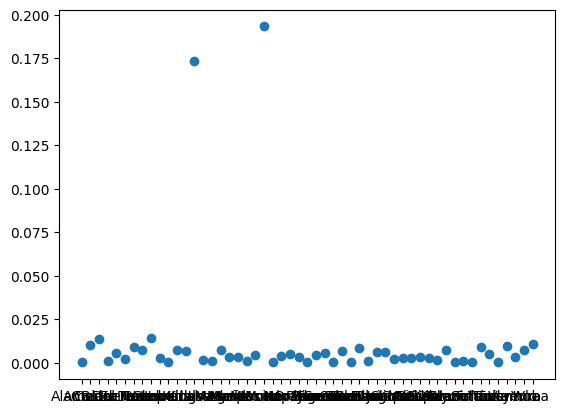

In [54]:
x1 = TD0['County']
y1 = TD0['IPC_AFTER']
plt.scatter(x1, y1)


In [55]:
# Omit unnamed column and IPC_BEFORE (this is a legacy of my previous research)
TD1 = TD0.drop(['Unnamed: 0', 'IPC_BEFORE'], axis = 1)


# Methods

In [56]:
# Test 1 - IPC ~ X using simple OLS
TD0.columns


Index(['Unnamed: 0', 'FEMA', 'FEMA_Adjascent', 'Median_Income', 'Percent_Own',
       'Med_Home_Price', 'IPC_BEFORE', 'IPC_AFTER', 'County',
       'Median_Age_House_Holder', 'Educ_HS_Grad', 'Educ_Some_College',
       'Educ_Bachelor_or_Higher', 'Race_White', 'Race_Black_AA',
       'Race_American_Indian_and_Alaska_Native', 'Race_Asian',
       'Race_Native_Hawaiian_and_Other_Pacific_Islander',
       'Race_Hispanic_or_Latino_origin'],
      dtype='object')

In [103]:
reg1 = smf.ols(formula = 'IPC_AFTER ~ Median_Income', data = TD0).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1558
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.695
Time:                        14:59:32   Log-Likelihood:                 103.53
No. Observations:                  53   AIC:                            -203.1
Df Residuals:                      51   BIC:                            -199.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0187      0.020      0.932

In [104]:
reg2 = smf.ols(formula = 'IPC_AFTER ~ Median_Income + Percent_Own', data = TD0).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.4438
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.644
Time:                        15:00:01   Log-Likelihood:                 103.92
No. Observations:                  53   AIC:                            -201.8
Df Residuals:                      50   BIC:                            -195.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0164      0.046     -0.359

In [105]:
reg3 = smf.ols(formula = 'IPC_AFTER ~ Median_Income + Percent_Own + Median_Age_House_Holder', data = TD0).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.3992
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.754
Time:                        15:00:04   Log-Likelihood:                 104.09
No. Observations:                  53   AIC:                            -200.2
Df Residuals:                      49   BIC:                            -192.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [106]:
reg4 = smf.ols(formula = 'IPC_AFTER ~ Median_Income + Percent_Own + Median_Age_House_Holder + Educ_Some_College', data = TD0).fit()
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.3046
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.873
Time:                        15:00:06   Log-Likelihood:                 104.12
No. Observations:                  53   AIC:                            -198.2
Df Residuals:                      48   BIC:                            -188.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [107]:
reg5 = smf.ols(formula = 'IPC_AFTER ~ Median_Income + Percent_Own + Median_Age_House_Holder + Educ_Some_College + Race_White', data = TD0).fit()
print(reg5.summary())

                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                    0.3175
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.900
Time:                        15:00:08   Log-Likelihood:                 104.33
No. Observations:                  53   AIC:                            -196.7
Df Residuals:                      47   BIC:                            -184.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

#### Test 2 - Random forest for causal factors

Goven the small number of observations and the low p-values in the initial tests, predictions using machine learning is not feasible. However, I can use random forests to find the largest contributing factors in an alternative causal inference model.

# Results

In [41]:
# Test 1 results


                            OLS Regression Results                            
Dep. Variable:              IPC_AFTER   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                    0.3175
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.900
Time:                        13:48:38   Log-Likelihood:                 104.33
No. Observations:                  53   AIC:                            -196.7
Df Residuals:                      47   BIC:                            -184.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

A simple cross-sectional analysis of 53 California counties is simply not enough data to determine the main factors behind solar adoption with a high degree of certainty. However, some insights can be gleaned from test 1:
- The lowest p-value is on race_white. Since race is highly correlated with age, education, income, and home ownership, this is not surprising. It is logical to beliee that each of these is an important factor in the decision to adopt solar power, and the prevalence of these factors among the older, wealthier white population makes sense.

# Discussion

Results have high p-values and do not lend themselves to accurate causdal inference or prediction models. 

# References